In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import os
from sklearn.metrics import f1_score
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime
from xgboost import XGBClassifier
from numpy import inf
import pickle
import random

C:\Users\omore\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Путь к директории с данными
data_dir = '../00_data/track_1/'
sumbit_dir = '../02_submits/'
preprocessed_dir = '../03_preprocessed_data/'

X_train = pd.read_csv(preprocessed_dir + 'X_train.csv')
X_test = pd.read_csv(preprocessed_dir + 'X_test.csv')
y_train = pd.read_csv(preprocessed_dir + 'y_train.csv')
y_test  = pd.read_csv(preprocessed_dir + 'y_test.csv')
X = pd.read_csv(preprocessed_dir + 'X.csv')

unused_features = [ 'is_test']
cat_col = [x for x in X_train.columns if 'code'  in x]
unused_features = unused_features + cat_col

use_for_train = ['year', 'station_id', 'day', 'ice_jam_same_day_last_year',
       'ice_jam_same_day_last_year_prev_stat', 'ice_jam_same_day_prelast_year',
       'is_prelast_year_missing', 'n_jams_last_year',
       'n_jams_prelast_year', 'n_jams_last_year_prev_station', 'n_jams_past',
       'n_jams_past_prev_stat', 'n_same_days_before',
       'n_ice_jams_same_days_before', 'n_ice_jams_same_days_before_ratio', 'station_width']

use_for_train = ['year', 'station_id', 'day', 
       'ice_jam_same_day_last_year', 
       'ice_jam_same_day_prelast_year', 
                 'is_last_year_missing',
       'is_prelast_year_missing', 
                 'n_jams_last_year',
                 'n_jams_prelast_year',
       'n_jams_past',  'n_ice_jams_same_days_before',
       'n_ice_jams_same_days_before_ratio',
       'distance_from_source', 'drainage_area', 'z_null', 
       'height_diff_by_dist']


C:\Users\omore\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (45,65,122,142,199,430,604,661,681) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\omore\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (45,65,122,142,199,276,604,661,681) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\omore\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (46,66,123,143,200,277,431,605,662,682) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
use_for_train = use_for_train + \
    [x for x in X_train.columns if 'stage_max'  in x] + \
    [x for x in X_train.columns if 'air'  in x] + \
    [x for x in X_train.columns if 'inc'  in x] 
use_for_train = list(set(use_for_train))

In [4]:
drop_summer = [x for x in X_train.columns if '6_'  in x] + \
    [x for x in X_train.columns if '7_'  in x] + \
    [x for x in X_train.columns if '8_'  in x]+ \
    [x for x in X_train.columns if '9_'  in x]

len(drop_summer)

308

In [5]:
#use_for_train = [x for x in X_train.columns if x not in (unused_features + ['ice_jam'] + drop_summer )]
len(use_for_train)

97

In [6]:
use_for_train

['7_stage_inc_monthly',
 '6_std_air',
 '11_mean_stage_max',
 '7_mean_air',
 '12_std_stage_max',
 '2_min_stage_max',
 'height_diff_by_dist',
 '10_mean_air',
 'drainage_area',
 '1_std_air',
 '6_mean_air',
 '1_std_stage_max',
 '9_std_stage_max',
 '1_min_air',
 '11_max_air',
 '2_stage_inc_monthly',
 '12_max_stage_max',
 '1_min_stage_max',
 '1_mean_stage_max',
 '8_min_stage_max',
 '11_mean_air',
 '12_min_air',
 '8_max_stage_max',
 '9_max_stage_max',
 '6_max_stage_max',
 'is_last_year_missing',
 '11_stage_inc_monthly',
 '8_std_stage_max',
 '6_std_stage_max',
 '12_std_air',
 '8_min_air',
 'z_null',
 '9_min_air',
 '10_mean_stage_max',
 '11_max_stage_max',
 '1_stage_inc_monthly',
 '10_stage_inc_monthly',
 '10_min_air',
 '6_mean_stage_max',
 '1_max_air',
 '1_mean_air',
 '7_min_stage_max',
 'ice_jam_same_day_last_year',
 'distance_from_source',
 '6_min_stage_max',
 'n_jams_past',
 '1_max_stage_max',
 'n_jams_last_year',
 '8_max_air',
 '8_std_air',
 'ice_jam_same_day_prelast_year',
 '7_max_stage_m

In [7]:
X_train_used = X_train[use_for_train]
# X_train_used = X_train[[use_for_train]].drop(unused_features, axis = 1)
X_test_used  = X_test[use_for_train]

# XGBoost

[0]	validation_0-error:0.16131
Will train until validation_0-error hasn't improved in 2 rounds.
[1]	validation_0-error:0.08980
[2]	validation_0-error:0.09895
[3]	validation_0-error:0.07733
[4]	validation_0-error:0.08065
[5]	validation_0-error:0.05432
[6]	validation_0-error:0.05903
[7]	validation_0-error:0.04490
[8]	validation_0-error:0.04074
[9]	validation_0-error:0.03852
[10]	validation_0-error:0.03437
[11]	validation_0-error:0.03326
[12]	validation_0-error:0.02605
[13]	validation_0-error:0.02079
[14]	validation_0-error:0.02439
[15]	validation_0-error:0.02079
Stopping. Best iteration:
[13]	validation_0-error:0.02079

F1-train: 0.3003952569169961
F1-test: 0.05063291139240506


Text(0.5, 0, 'XGBoost Importance')

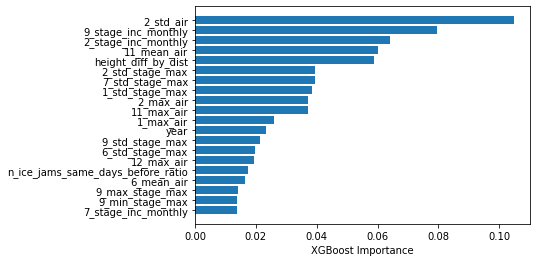

In [12]:
random.seed(10)
np.random.seed(10)
model = XGBClassifier(scale_pos_weight = 50, n_estimators = 500, random_state=1, seed = 1)
eval_set =[(X_test_used, y_test)]
model.fit(X_train_used, y_train, early_stopping_rounds = 2, 
                      eval_metric="error",
                     eval_set=eval_set , verbose=True)   

y_pred = model.predict(X_test_used)
y_train_pred = model.predict(X_train_used)

print('F1-train: {}'.format(f1_score(y_train, y_train_pred)))
print('F1-test: {}'.format(f1_score(y_test, y_pred)))

importances = model.feature_importances_
feature_names = X_train_used.columns
sorted_idx = importances.argsort()[-20:]


plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.xlabel("XGBoost Importance")


In [9]:
X_used = X[use_for_train + ['is_test', 'ice_jam']  ]
all_train = X_used[(X_used['is_test'] == False)].drop('ice_jam', axis = 1).reset_index(drop=True)
X_val = X_used[(X_used['is_test'] == True)].drop('ice_jam', axis = 1).reset_index(drop=True)
all_y_train =  X_used.loc[(X_used['is_test'] == False),'ice_jam']
mod_opt= model.fit(all_train, all_y_train)

X_val['ice_jam'] = mod_opt.predict(X_val)
now = datetime.now()
X_val[['year', 'station_id', 'day', 'ice_jam']].\
    to_csv(sumbit_dir + 'submit-rf' + now.strftime("%m-%d-%Y-%H-%M") + '.csv', index=False)

Сохраним модель

In [10]:
pickle.dump(model, open(sumbit_dir + 'submit-rf' + now.strftime("%m-%d-%Y-%H-%M") + '.pkl', 'wb'))